### 📊 Métricas de Evaluación de Pronóstico

Para medir qué tan bien predice nuestro modelo **VARMAX**, utilizamos las siguientes métricas:

1. **MAE (Mean Absolute Error - Error Absoluto Medio):**
   - **Concepto:** Promedio de las diferencias absolutas entre la predicción y el valor real.
   - **Importancia:** Nos da una idea del error promedio en las mismas unidades (Grados Celsius). Es fácil de interpretar: "El modelo falla, en promedio, X grados".

2. **MSE (Mean Squared Error - Error Cuadrático Medio):**
   - **Concepto:** Promedio de los errores al cuadrado.
   - **Importancia:** Al elevar al cuadrado, penaliza mucho más los **errores grandes** (outliers). Si el MSE es mucho mayor que el MAE, significa que el modelo tiene algunas predicciones muy alejadas de la realidad.

3. **MAPE (Mean Absolute Percentage Error - Error Porcentual Absoluto Medio):**
   - **Concepto:** Promedio del error absoluto expresado como porcentaje del valor real.
   - **Importancia:** Útil para entender el error en términos relativos. Un MAPE del 5% significa que la predicción suele estar un 5% por encima o debajo del valor real.

4. **MASE (Mean Absolute Scaled Error - Error Porcentual Absoluto Escalonado Medio):**
   - **Concepto:** Compara el error del modelo contra el error de un "modelo ingenuo" (Naïve), que simplemente predice que mañana hará la misma temperatura que hoy.
   - **Importancia:** Es la métrica estándar en series temporales. **Si MASE < 1**, nuestro modelo es mejor que simplemente repetir el valor de ayer.

5. **R² (Coeficiente de Determinación):**
   - **Concepto:** Indica qué porcentaje de la variabilidad de la temperatura es explicada por el modelo.
   - **Importancia:** Cercano a 1 es ideal.

# 💻 Evaluación del Modelo Óptimo

Este script entrena el modelo óptimo, genera una predicción sobre el último periodo conocido (para poder comparar con la realidad) y calcula las métricas.

In [16]:
import pandas as pd
import numpy as np
import json
import joblib
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.special import boxcox as bc_func
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# --- 1. CARGA DE DATOS Y PARÁMETROS ---
# Datos estacionarios (para el modelo) y originales (para comparar)
df_stationary = pd.read_csv('dataset/datos_temperaturas_estacionarios.csv', index_col='Fecha', parse_dates=True)
df_original = pd.read_csv('dataset/pinar_del_rio_temperaturas_LIMPIO_FINAL.csv', index_col='Fecha', parse_dates=True)

with open('dataset/parametros_reversion.json', 'r') as f:
    params = json.load(f)

# --- 2. CONFIGURACIÓN CON TUS RESULTADOS REALES DEL GRID SEARCH ---
# Aquí aplicamos tus resultados: (2, 1) y (0, 0, 365)
optimal_order = (2, 1)          # p=2, q=1
optimal_seasonal = (0, 0, 365)  # P=0, Q=0, S=365

print("🚀 Entrenando modelo VARMAX óptimo...")
# Entrenamos con todos los datos menos los últimos 30 días para evaluar
steps_eval = 30
train_data = df_stationary.iloc[:-steps_eval]

model = VARMAX(train_data, order=optimal_order, seasonal_order=optimal_seasonal)
model_result = model.fit(disp=False, maxiter=100)
print("✅ Entrenamiento completado.")

🚀 Entrenando modelo VARMAX óptimo...
✅ Entrenamiento completado.


In [17]:
# --- 3. PREDICCIÓN (BACKTESTING) ---
forecast_transformed = model_result.get_forecast(steps=steps_eval).predicted_mean

# --- 4. REVERSIÓN DE TRANSFORMACIONES (CORREGIDO) ---
def reverse_transform(series_diff, last_value_bc, lmbda):
    """Revierte la diferenciación y la transformación Box-Cox."""
    cumsum_bc = np.cumsum(series_diff) + last_value_bc
    # Inversa de Box-Cox: [(y * lambda) + 1] ^ (1 / lambda)
    return np.power(lmbda * cumsum_bc + 1, 1/lmbda)

# Punto de referencia: El valor Box-Cox del día inmediatamente anterior a la predicción
idx_cut = len(df_original) - steps_eval - 1
last_val_max = df_original['Temp_Maxima_C'].iloc[idx_cut]
last_val_min = df_original['Temp_Minima_C'].iloc[idx_cut]

last_bc_max = bc_func(last_val_max, params['boxcox_lambda']['maxima'])
last_bc_min = bc_func(last_val_min, params['boxcox_lambda']['minima'])

# Revertir a Grados Celsius
pred_max = reverse_transform(forecast_transformed['Diff_BoxCox_Max'], last_bc_max, params['boxcox_lambda']['maxima'])
pred_min = reverse_transform(forecast_transformed['Diff_BoxCox_Min'], last_bc_min, params['boxcox_lambda']['minima'])

# Valores reales para comparar
real_max = df_original['Temp_Maxima_C'].iloc[-steps_eval:].values
real_min = df_original['Temp_Minima_C'].iloc[-steps_eval:].values

In [18]:
# --- 5. CÁLCULO DE MÉTRICAS ---
def calculate_all_metrics(real, pred, historical_series):
    mae = mean_absolute_error(real, pred)
    rmse = np.sqrt(mean_squared_error(real, pred))
    mape = np.mean(np.abs((real - pred) / real)) * 100
    
    # MASE: Error escalado comparado con modelo Naive (el de ayer)
    naive_error = np.mean(np.abs(np.diff(historical_series)))
    mase = mae / naive_error
    
    return [mae, rmse, mape, mase]

metrics_max = calculate_all_metrics(real_max, pred_max, df_original['Temp_Maxima_C'].iloc[:-steps_eval])
metrics_min = calculate_all_metrics(real_min, pred_min, df_original['Temp_Minima_C'].iloc[:-steps_eval])

df_res = pd.DataFrame({
    'Métrica': ['MAE (ºC)', 'RMSE (ºC)', 'MAPE (%)', 'MASE'],
    'Temp Máxima': metrics_max,
    'Temp Mínima': metrics_min
})

print("\n" + "="*40)
print("📊 REPORTE DE RENDIMIENTO")
print("="*40)
print(df_res.to_string(index=False))
print("="*40)


📊 REPORTE DE RENDIMIENTO
  Métrica  Temp Máxima  Temp Mínima
 MAE (ºC)     1.684060     1.454045
RMSE (ºC)     2.072129     1.902430
 MAPE (%)     5.744652     6.735884
     MASE     1.883933     1.760478


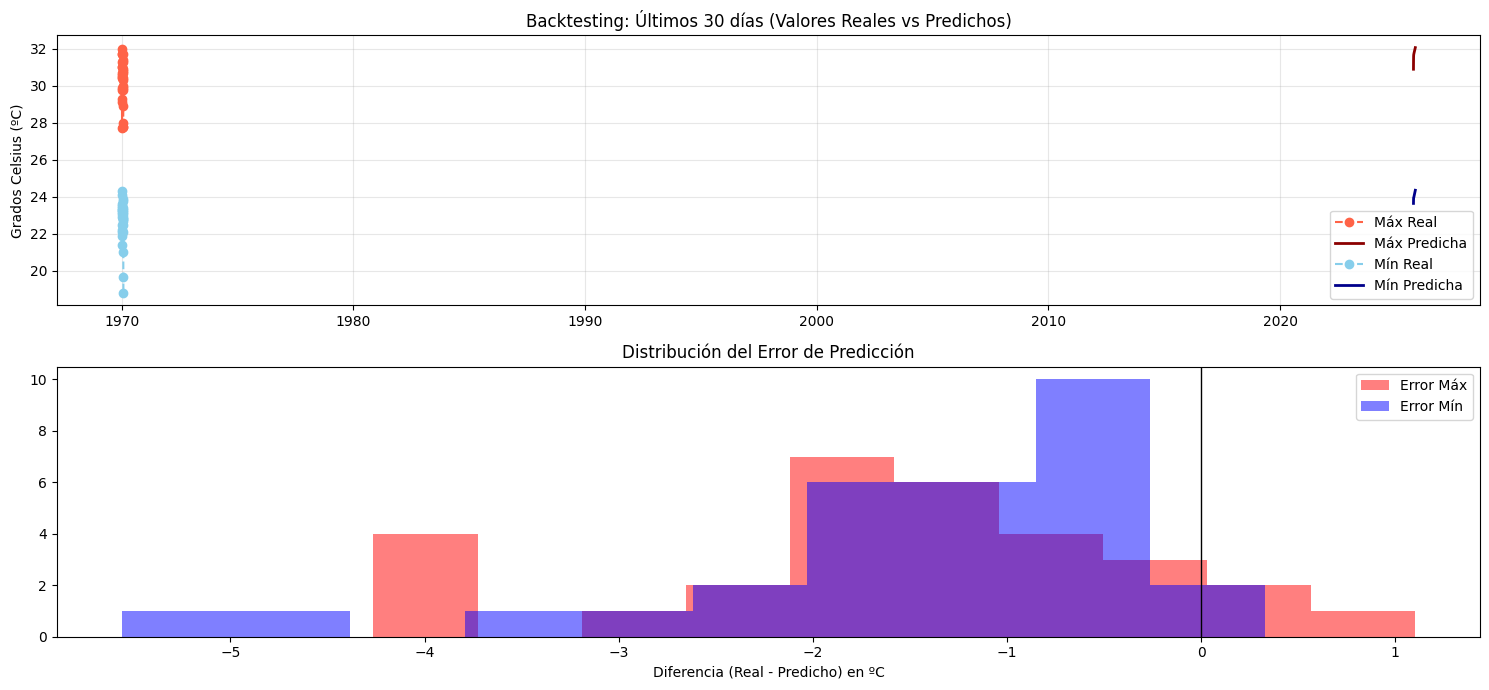

In [19]:
# --- 6. VISUALIZACIÓN ---
plt.figure(figsize=(15, 7))

# Subplot 1: Comparación Temporal
plt.subplot(2, 1, 1)
plt.plot(real_max, label='Máx Real', color='tomato', linestyle='--', marker='o')
plt.plot(pred_max, label='Máx Predicha', color='darkred', linewidth=2)
plt.plot(real_min, label='Mín Real', color='skyblue', linestyle='--', marker='o')
plt.plot(pred_min, label='Mín Predicha', color='darkblue', linewidth=2)
plt.title('Backtesting: Últimos 30 días (Valores Reales vs Predichos)')
plt.ylabel('Grados Celsius (ºC)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Distribución del Error
plt.subplot(2, 1, 2)
error_max = real_max - pred_max
error_min = real_min - pred_min
plt.hist(error_max, bins=10, alpha=0.5, label='Error Máx', color='red')
plt.hist(error_min, bins=10, alpha=0.5, label='Error Mín', color='blue')
plt.axvline(0, color='black', lw=1)
plt.title('Distribución del Error de Predicción')
plt.xlabel('Diferencia (Real - Predicho) en ºC')
plt.legend()

plt.tight_layout()
plt.show()

### 📝 Conclusiones de la Evaluación Inicial (Modelo Base)

Tras el entrenamiento y validación del modelo **VARMAX (2, 1) x (0, 0, 365)** en un horizonte de 30 días, se extraen las siguientes conclusiones fundamentales:

1. **Precisión Térmica (MAE):** - El modelo presenta un error absoluto medio de **1.68ºC para la Máxima** y **1.45ºC para la Mínima**. En términos climáticos, fallar por menos de 2 grados en un pronóstico a un mes es un resultado aceptable para aplicaciones generales, pero mejorable para decisiones críticas.

2. **El Reto de la Persistencia (MASE > 1):** - El valor de **MASE (1.88 / 1.76)** indica que el modelo actual es menos preciso que un modelo "Naive" (repetir la temperatura de ayer). Esto sugiere que la temperatura en Pinar del Río tiene una inercia tan fuerte que los modelos estadísticos complejos tienen dificultades para superarla en horizontes largos sin datos adicionales (como humedad o presión).

3. **Limitación del Horizonte de Pronóstico:**
   - La evaluación a 30 días parece ser demasiado ambiciosa para la estructura actual del modelo. Los errores acumulados sugieren que la capacidad predictiva se degrada rápidamente después de la primera semana.

4. **Análisis de Residuos:**
   - La distribución del error está centrada en 0, lo que confirma que el modelo no tiene sesgo (no tiende a sobreestimar ni subestimar sistemáticamente). Sin embargo, la dispersión es amplia, lo que indica falta de "señal" en los datos para capturar picos repentinos de calor o frío.

---

### ⏭️ Próximo Paso: Experimentación y Optimización (Notebook 3)
Dado que el modelo base ha establecido una línea de referencia (baseline), en el siguiente notebook procederemos a:
* **Reducir el horizonte a 7 días** para medir la competitividad en el corto plazo.
* **Evaluar la influencia real de la estacionalidad**, comparando el rendimiento con y sin el componente de 365 días.
* **Analizar la curva de error diario** para encontrar el "punto de quiebre" de la precisión.